# Streamline model: calculation of several streamline models at the same time

The idea is to test if a family of streamline model solutions can fit the profile we see, instead of showing only one solution.

## Preliminaries

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord, FK5
import pyspeckit
import os
import sys
sys.path.append('../../../B5_NOEMA_30m')
from B5setup import *
from astropy.wcs import WCS
import velocity_tools.stream_lines as SL
import velocity_tools.coordinate_offsets as c_offset
import matplotlib.pyplot as plt
from astropy.constants import k_B, m_p
%matplotlib inline

block_reduce was moved to the astropy.nddata.blocks module.  Please update your import statement.


In [10]:
def get_streamer(mass, r0, theta0, phi0, omega0, v_r0, inc, PA, rmin=0):
    (x1, y1, z1), (vx1, vy1, vz1) = SL.xyz_stream(
        mass=mass, r0=r0, theta0=theta0, phi0=phi0,
        omega=omega0, v_r0=v_r0, inc=inc, pa=PA, rmin=(250*u.au if rmin==0 else rmin)) #, deltar=10*u.au)
    # we obtain the distance of each point in the sky
    d_sky_au = np.sqrt(x1**2 + z1**2)
    # Stream line into arcsec
    dra_stream = -x1.value / dist_B5.value
    ddec_stream = z1.value / dist_B5.value
    fil = SkyCoord(dra_stream*u.arcsec, ddec_stream*u.arcsec,
                   frame=B5_ref).transform_to(FK5)
    velocity = v_lsr + vy1
    return fil, d_sky_au, velocity


def plot_image_and_KDE(fig, data, kdedata, wcs, intmin=0, intmax=10, velmin=9, 
                       velmax=11, xmin=0, xmax=2000, regionplot=None, velobject=10.2, 
                       axis_new=None, new_ax_color='red', cmap='Greys'):
    ax1 = fig.add_subplot(121, projection=wcs)
    imageplane = ax1.imshow(data, vmin=intmin, vmax=intmax, origin='lower', cmap=cmap)
    fig.colorbar(imageplane, ax=ax1)
    ax1.set_autoscale_on(False)
    ax1.plot(ra_yso, dec_yso, transform=ax1.get_transform('fk5'), marker='*', color='red')
    ax1.set_xlabel('Right Ascension (J2000)')
    ax1.set_ylabel('Declination (J2000)')
    if regionplot is not None:
        patch_list, artist_list = regionplot.get_mpl_patches_texts()
        for p in patch_list:
            ax1.add_patch(p)
        for a in artist_list:
            ax1.add_artist(a)
    if axis_new is not None:
        ax1.plot(axis_new.ra[1:], axis_new.dec[1:], transform=ax1.get_transform('fk5'), color=new_ax_color)
        ax1.plot(axis_new.ra[0:2], axis_new.dec[0:2], transform=ax1.get_transform('fk5'), color='red')
    
    ax2 = fig.add_subplot(122)
    ax2.set_xlabel('Projected distance (au)')
    ax2.set_ylabel(r"V$_{lsr}$ (km s$^{-1}$)")
    xx, yy, zz = kdedata
    ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
    ax2.axhline(velobject, color='k', ls=':')
    ax2.set_ylim([velmin,velmax])
    ax2.set_xlim([xmin,xmax])
    
    return ax1, ax2

In [3]:
# Filenames
folder = 'gaussfit_H2CO/'
paramcubename_blue = 'components_blueshifted_envelope'
paramflagname_blue = paramcubename_blue + '_flag_repeated.fits'
imagename_blue = paramcubename_blue + '_Tpeak.fits'
vcname_blue = paramcubename_blue + '_vlsr.fits'
sigmaname_blue = paramcubename_blue + '_sigmav.fits'
sigmaname_nt_blue = paramcubename_blue + '_sigmav_nt.fits'
machvelname_blue = paramcubename_blue + '_Mach_nt.fits'

velkde_file = paramcubename_blue +'_kde.npy' # we already calculated the KDE so why do it again

# parameters
M_star = 0.2 * u.Msun # from our PV diagram analysis
M_disk = 0.032 * u.Msun # corrected from 240 to 302 pc distance from Zapata et al 2014
M_env = 0.33 * u.Msun # corrected from 240 to 302 pc distance from Brassfield and Bourke 2011
Mtot = M_star + M_disk + M_env
v_lsr = 10.2 * u.km/u.s
inc = (13) * u.deg
PA_ang = (157+90)*u.deg

## Setting up the path from where to extract models

In [4]:
xx, yy, zz = np.load(velkde_file)
B5_c = SkyCoord(ra_yso*u.deg, dec_yso*u.deg, frame='fk5')
B5_ref = B5_c.skyoffset_frame()
# axes given by i and PA
x_b = np.array([1, 0, 0])*1e3/dist_B5.value
y_b = np.array([0, 0, 0])*1e3/dist_B5.value
z_b = np.array([0, 0, 1])*1e3/dist_B5.value
nx_b, ny_b, nz_b = SL.rotate_xyz(x_b, y_b, z_b, inc=inc, pa=PA_ang)
my_axis_new = SkyCoord(-nx_b*u.arcsec, nz_b*u.arcsec, frame=B5_ref).transform_to(FK5)
if ny_b[-1] > 0:
    new_ax_color = 'red'
else:
    new_ax_color = 'blue'

In [8]:
# These are the parameters of the main streamline
r0_blue = 2660 * u.au
theta0_blue = 101 * u.deg  # rotate clockwise
phi0_blue = 71 * u.deg
v_r0_blue = 0.0 * u.km/u.s
omega0_blue = 3.1e-13 / u.s
r_c = SL.r_cent(Mtot,omega0_blue,r0_blue)
# fil0_blue, dsky0_blue, velo0_blue = get_streamer(Mtot, r0_blue, theta0_blue, phi0_blue, omega0_blue, v_r0_blue, inc, PA_ang, rmin=r_c.value)

# we determined the following relation (approximated to a line, but now that I think about it there should be a cosine somewhere)
theta_list = np.linspace(101, 144, 20) * u.deg
phi_list = (0.7442*theta_list - 4.1642*u.deg)

In [11]:
curveslist = []
for i in range(len(theta_list)):
    fil0_blue, dsky0_blue, velo0_blue = get_streamer(Mtot, r0_blue, theta_list[i], phi_list[i], omega0_blue, v_r0_blue, inc, PA_ang, rmin=r_c)
    curveslist.append([fil0_blue, dsky0_blue, velo0_blue])


rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU
rc=215.96243758477576 AU


'obsfix' made the change 'Set OBSGEO-L to   -67.754929 from OBSGEO-[XYZ].
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


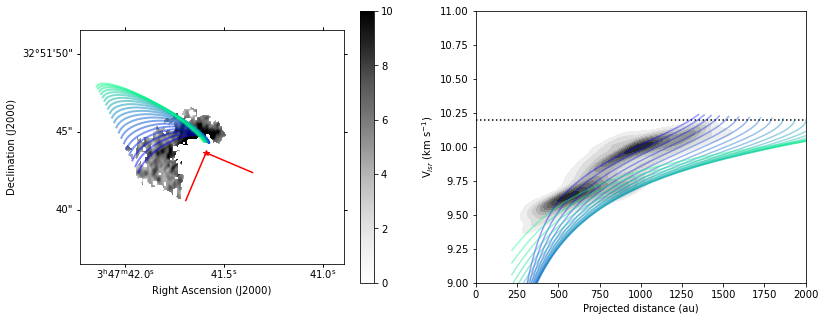

In [24]:
Tpeak_blue = fits.getdata(imagename_blue)
wcs = WCS(fits.getheader(imagename_blue))
colors = [plt.cm.winter(each) for each in np.linspace(0, 1, len(theta_list))]

fig = plt.figure(figsize=(13,5))
ax1, ax2 = plot_image_and_KDE(fig, Tpeak_blue, (xx, yy, zz), wcs, regionplot=None, axis_new=my_axis_new, new_ax_color=new_ax_color)

for i in range(len(theta_list)):
    fil0_blue, dsky0_blue, velo0_blue = curveslist[i]
    line_image, = ax1.plot(fil0_blue.ra, fil0_blue.dec, transform=ax1.get_transform('fk5'), ls='-', lw=2, alpha=0.5, color=colors[i])
    line_vel, = ax2.plot(dsky0_blue, velo0_blue, linestyle='-', alpha=0.4, color=colors[i])